In [7]:
import hydra
import jax.numpy as jnp
import matplotlib.pyplot as plt
import jax
from omegaconf import OmegaConf
from jaxman.env.pick_and_delivery.env import JaxPandDEnv
from jaxman.utils import compute_agent_action
from jaxman.utils import compute_agent_action
from jaxman.planner.rl_planner.agent.dqn.dqn import create_dqn_agent
from flax.training import checkpoints
config = hydra.utils.instantiate(OmegaConf.load("../scripts/config/env/pick_and_delivery/grid.yaml"))
model_config = hydra.utils.instantiate(OmegaConf.load("../scripts/config/model/dqn.yaml"))
config.level=0
config.map_size=15
config.num_agents=1
config.num_items=2
config.is_decay_reward=False
config.is_biased_sample=True
env = JaxPandDEnv(config)
key = jax.random.PRNGKey(0)

def compute_q_value(actor, obs):
    communication=jnp.array([[[0, 0, 0, 0]]])
    agent_obs = obs.split_observation()
    agent_obs = agent_obs._replace(communication=communication)
    q = jnp.max(actor.apply_fn({"params": actor.params}, agent_obs))
    return q
    

In [8]:
agent, key = create_dqn_agent(env.observation_space, env.act_space, model_config, key)
actor = agent.actor
actor = checkpoints.restore_checkpoint(
    ckpt_dir="../model/pick_and_delivery_random/",
    target=actor,
    prefix="grid_actor_single",
)

Text(0.5, 1.0, 'q = 3.228')

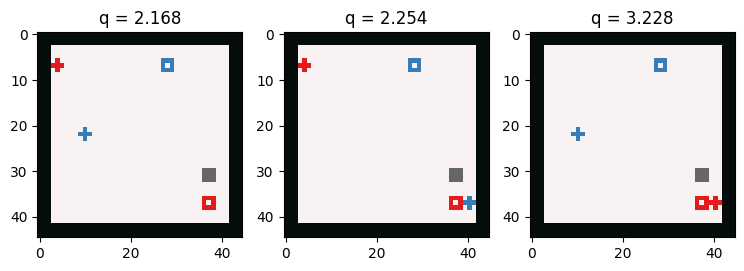

In [9]:
obs = env.reset(key=jax.random.PRNGKey(0))
fig, axes = plt.subplots(1, 3, figsize=(9, 3))
## case 0
axes[0].imshow(env.render())
q = compute_q_value(actor, obs)
axes[0].set_title("q = {:.4g}".format(q))

## case 2
obs = env.reset(key=jax.random.PRNGKey(0))
new_pos = env.state.agent_state.pos[0][0] + jnp.array([1,0])
item_pos = env.state.item_pos.at[1].set(new_pos)
env.state = env.state._replace(item_pos = item_pos)
obs = env._observe(env.state, env.task_info, env.trial_info)
q = compute_q_value(actor, obs)
axes[1].imshow(env.render())
axes[1].set_title("q = {:.4g}".format(q))

## case 2
obs = env.reset(key=jax.random.PRNGKey(0))
new_pos = env.state.agent_state.pos[0][0] + jnp.array([1,0])
item_pos = env.state.item_pos.at[0].set(new_pos)
env.state = env.state._replace(item_pos = item_pos)
obs = env._observe(env.state, env.task_info, env.trial_info)
q = compute_q_value(actor, obs)
axes[2].imshow(env.render())
axes[2].set_title("q = {:.4g}".format(q))

# Q-value trend by item-time when agent don't hold item

(0.0, 100.0)

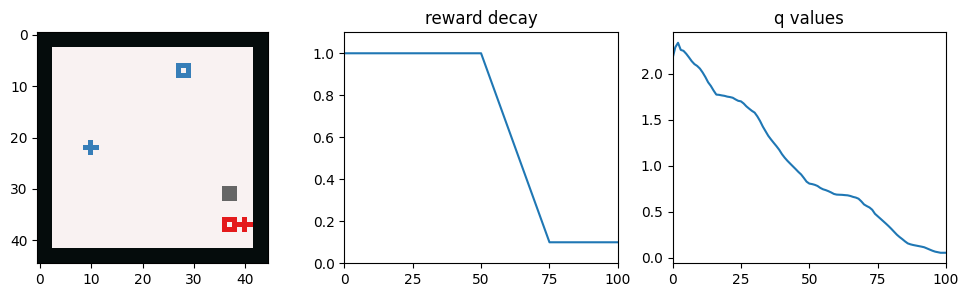

In [49]:
## initialized env
obs = env.reset(key=jax.random.PRNGKey(0))
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

obs = env.reset(key=jax.random.PRNGKey(0))
new_pos = env.state.agent_state.pos[0][0] + jnp.array([1,0])
item_pos = env.state.item_pos.at[0].set(new_pos)
env.state = env.state._replace(item_pos=item_pos)
axes[0].imshow(env.render())

## reward decay
def compute_solve_rew(time):
    decay_duration = config.decay_end - config.decay_start
    decay_scale = 1 - config.min_reward
    solve_rew = jnp.clip(
        1
        - decay_scale
        * (time - config.decay_start)
        / decay_duration,
        a_min=config.min_reward,
        a_max=1,
    )
    return solve_rew

X = jnp.arange(101)
Y = compute_solve_rew(X)
axes[1].plot(X,Y)
axes[1].set_title("reward decay")
axes[1].set_xticks([0,25,50,75,100])
axes[1].set_xlim(0,100)
axes[1].set_ylim(0,1.1)

## agent q value trend by item_time
qs = []
for i in range(101):
    item_info = obs.item_info.at[0,0,-1].set(i).at[0,1,-1].set(i)
    obs_i = obs._replace(item_info=item_info)
    qs.append(compute_q_value(actor, obs_i))
axes[2].plot(jnp.arange(101), jnp.array(qs))
axes[2].set_title("q values")
axes[2].set_xticks([0,25,50,75,100])
axes[2].set_xlim(0,100)
# axes[1].set_ylim(0,1.1)

# Q-value trend by item-time when agent carrying item

(0.0, 100.0)

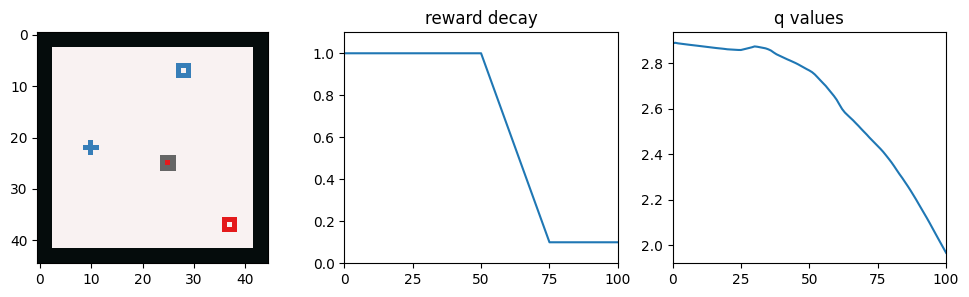

In [51]:
## initialized env
obs = env.reset(key=jax.random.PRNGKey(0))
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

obs = env.reset(key=jax.random.PRNGKey(0))
is_item_loaded = jnp.expand_dims(jnp.arange(config.num_items) < config.num_agents, -1)
item_pos = (env.state.item_pos + is_item_loaded * 10000).astype(int)
agent_state = env.state.agent_state._replace(pos = jnp.array([[8, 8]]))
env.state = env.state._replace(agent_state = agent_state, load_item_id = jnp.arange(config.num_agents)
                              ,item_pos = item_pos)
obs = env._observe(env.state, env.task_info, env.trial_info)
axes[0].imshow(env.render())

## reward decay
def compute_solve_rew(time):
    decay_duration = config.decay_end - config.decay_start
    decay_scale = 1 - config.min_reward
    solve_rew = jnp.clip(
        1
        - decay_scale
        * (time - config.decay_start)
        / decay_duration,
        a_min=config.min_reward,
        a_max=1,
    )
    return solve_rew

X = jnp.arange(101)
Y = compute_solve_rew(X)
axes[1].plot(X,Y)
axes[1].set_title("reward decay")
axes[1].set_xticks([0,25,50,75,100])
axes[1].set_xlim(0,100)
axes[1].set_ylim(0,1.1)

# agent q value trend by item_time
qs = []
for i in range(101):
    item_time = obs.item_time.at[0].set(i)
    obs_i = obs._replace(item_time=item_time)
    qs.append(compute_q_value(actor, obs_i))
axes[2].plot(jnp.arange(101), jnp.array(qs))
axes[2].set_title("q values")
axes[2].set_xticks([0,25,50,75,100])
axes[2].set_xlim(0,100)